# Iterative하게 모든 SAMPLE에 대해서 Training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기

In [2]:
data = pd.read_csv('./TrafficData/3-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

In [3]:
from torch import FloatTensor as FloatTensor

In [4]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [5]:
split = 10080

In [6]:
seed = 42

In [7]:
device = torch.device("cuda:0")

In [8]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [9]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[27063.]])

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 2. Train-Validation set으로 쪼개기

In [11]:
data

0        27521
1        27698
2        25710
3        23148
4        21683
         ...  
38875    20838
38876    21617
38877    21622
38878    21158
38879    21926
Name: volumn, Length: 38880, dtype: int64

* 10080개는 test set 
* 28800개 중 0.2의 비율인 1440*4 = 5760개는 validation set
* 28800개 중 0.8의 비율인 28800-5760 = 23040개는 train set

In [12]:
train = data.iloc[:-split-5760]
val = data.iloc[-split-5760:-split]
x_train,y_train = seq_data(train,sequence_length=1440,pred_len=1)
x_val,y_val = seq_data(val,sequence_length=1440,pred_len=1)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_183418/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
next(iter(validation))[0].size()

torch.Size([64, 1, 1440])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [14]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(1440)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [15]:
import copy

In [16]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=200
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)  
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 14.803
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 20.275
Epoch [41]/[100] running accumulative loss across all batches: 14.601
Epoch [61]/[100] running accumulative loss across all batches: 15.752
Epoch [81]/[100] running accumulative loss across all batches: 14.629
changed


### validation set에 대해서 attribution 구하기

In [17]:
n = len(validation)
n

68

In [18]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,1440))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [19]:
len(nt_ig_attr_score)

1440

<AxesSubplot: >

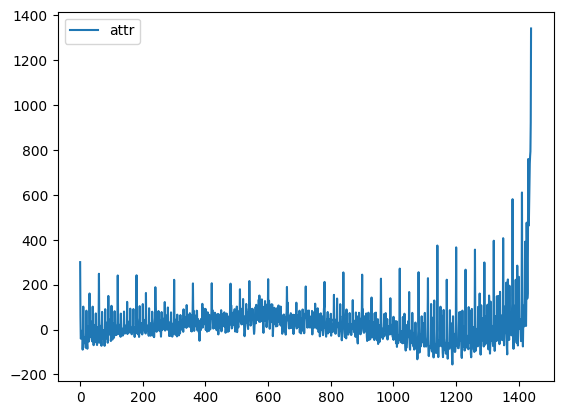

In [20]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### outlier가 감쇄 됐음을 확인할 수 있다.

#### scaling

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,2.888755
1,0.414316
2,-0.643332
3,-0.608931
4,-0.471660
...,...
1435,7.453996
1436,7.786792
1437,7.999766
1438,9.342738


#### train_index구하기

In [22]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [23]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


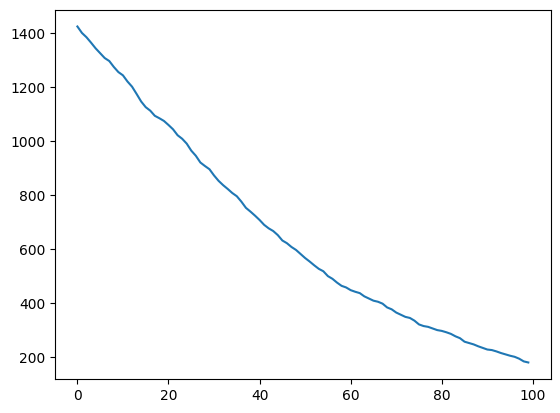

In [24]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [25]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[33777., 30678., 26785.,  ..., 22870., 22070., 24058.]],

        [[30678., 26785., 24883.,  ..., 22070., 24058., 30562.]],

        [[26785., 24883., 23174.,  ..., 24058., 30562., 28446.]],

        ...,

        [[28204., 24162., 22908.,  ..., 22308., 22386., 30558.]],

        [[24162., 22908., 20897.,  ..., 22386., 30558., 28307.]],

        [[22908., 20897., 21384.,  ..., 30558., 28307., 24778.]]],
       device='cuda:0') tensor([[[30562.]],

        [[28446.]],

        [[26605.]],

        [[24700.]],

        [[22775.]],

        [[22747.]],

        [[23902.]],

        [[24679.]],

        [[24743.]],

        [[25708.]],

        [[29977.]],

        [[27451.]],

        [[27162.]],

        [[22791.]],

        [[22300.]],

        [[22325.]],

        [[24892.]],

        [[23688.]],

        [[22577.]],

        [[23223.]],

        [[27037.]],

        [[24391.]],

        [[23790.]],

        [[21673.]],

        [[20771.]],

        [[21279.]],

        [[2252

       device='cuda:0') tensor([[[21800.]],

        [[22165.]],

        [[21802.]],

        [[21865.]],

        [[25338.]],

        [[25126.]],

        [[22181.]],

        [[20932.]],

        [[21129.]],

        [[20001.]],

        [[22191.]],

        [[21709.]],

        [[21635.]],

        [[23117.]],

        [[25658.]],

        [[25121.]],

        [[23891.]],

        [[23099.]],

        [[21437.]],

        [[22049.]],

        [[22560.]],

        [[22744.]],

        [[22228.]],

        [[21592.]],

        [[26374.]],

        [[25491.]],

        [[23228.]],

        [[21454.]],

        [[18902.]],

        [[20472.]],

        [[22313.]],

        [[22877.]],

        [[22232.]],

        [[23658.]],

        [[27490.]],

        [[24019.]],

        [[22757.]],

        [[21334.]],

        [[20509.]],

        [[21384.]],

        [[22398.]],

        [[23346.]],

        [[22638.]],

        [[22025.]],

        [[26249.]],

        [[25484.]],

        [[

       device='cuda:0') tensor([[[22863.]],

        [[22244.]],

        [[21004.]],

        [[21759.]],

        [[21742.]],

        [[22162.]],

        [[22296.]],

        [[21864.]],

        [[25711.]],

        [[23900.]],

        [[22673.]],

        [[22399.]],

        [[19140.]],

        [[20890.]],

        [[21117.]],

        [[20919.]],

        [[21556.]],

        [[21932.]],

        [[26060.]],

        [[24004.]],

        [[23195.]],

        [[22182.]],

        [[19421.]],

        [[19633.]],

        [[21376.]],

        [[21231.]],

        [[21282.]],

        [[22611.]],

        [[27134.]],

        [[24432.]],

        [[23871.]],

        [[20726.]],

        [[19666.]],

        [[19473.]],

        [[20664.]],

        [[21128.]],

        [[20683.]],

        [[20970.]],

        [[24876.]],

        [[23267.]],

        [[22050.]],

        [[21258.]],

        [[20159.]],

        [[19878.]],

        [[21024.]],

        [[21135.]],

        [[

tensor([[[19206., 18432., 17102.,  ..., 18578., 22858., 21708.]],

        [[18432., 17102., 18179.,  ..., 22858., 21708., 19608.]],

        [[17102., 18179., 19320.,  ..., 21708., 19608., 21038.]],

        ...,

        [[23565., 18027., 19604.,  ..., 21792., 21200., 19965.]],

        [[18027., 19604., 20582.,  ..., 21200., 19965., 19048.]],

        [[19604., 20582., 19715.,  ..., 19965., 19048., 16964.]]],
       device='cuda:0') tensor([[[19608.]],

        [[21038.]],

        [[17525.]],

        [[17284.]],

        [[18214.]],

        [[18439.]],

        [[18684.]],

        [[19158.]],

        [[25714.]],

        [[22437.]],

        [[19803.]],

        [[18336.]],

        [[17018.]],

        [[17460.]],

        [[17723.]],

        [[18057.]],

        [[18432.]],

        [[18661.]],

        [[21622.]],

        [[21309.]],

        [[19404.]],

        [[21105.]],

        [[16848.]],

        [[17301.]],

        [[18404.]],

        [[18720.]],

        [[1887

       device='cuda:0') tensor([[[21816.]],

        [[19795.]],

        [[23181.]],

        [[22801.]],

        [[21888.]],

        [[20772.]],

        [[19555.]],

        [[18436.]],

        [[19146.]],

        [[19953.]],

        [[19780.]],

        [[19895.]],

        [[23191.]],

        [[23528.]],

        [[22362.]],

        [[21370.]],

        [[19131.]],

        [[20542.]],

        [[21541.]],

        [[20421.]],

        [[19315.]],

        [[19848.]],

        [[24085.]],

        [[23238.]],

        [[22144.]],

        [[21162.]],

        [[19131.]],

        [[18717.]],

        [[19764.]],

        [[19663.]],

        [[19056.]],

        [[19169.]],

        [[23829.]],

        [[24231.]],

        [[22810.]],

        [[22188.]],

        [[18862.]],

        [[19639.]],

        [[19456.]],

        [[19789.]],

        [[19713.]],

        [[20199.]],

        [[24198.]],

        [[24125.]],

        [[24279.]],

        [[21072.]],

        [[

       device='cuda:0') tensor([[[18012.]],

        [[18909.]],

        [[17974.]],

        [[19084.]],

        [[18743.]],

        [[18662.]],

        [[22382.]],

        [[23815.]],

        [[21231.]],

        [[19537.]],

        [[18317.]],

        [[19606.]],

        [[17219.]],

        [[18137.]],

        [[17968.]],

        [[19083.]],

        [[23202.]],

        [[22015.]],

        [[21112.]],

        [[19271.]],

        [[17780.]],

        [[19950.]],

        [[18696.]],

        [[18957.]],

        [[18519.]],

        [[18506.]],

        [[22974.]],

        [[21761.]],

        [[21036.]],

        [[18894.]],

        [[17245.]],

        [[18650.]],

        [[19380.]],

        [[18802.]],

        [[18108.]],

        [[18452.]],

        [[22113.]],

        [[21601.]],

        [[21301.]],

        [[19899.]],

        [[17215.]],

        [[18223.]],

        [[18773.]],

        [[20127.]],

        [[17608.]],

        [[17961.]],

        [[

tensor([[[18198., 20344., 20470.,  ..., 22228., 21717., 22662.]],

        [[20344., 20470., 19992.,  ..., 21717., 22662., 21787.]],

        [[20470., 19992., 19701.,  ..., 22662., 21787., 18984.]],

        ...,

        [[19159., 18922., 20761.,  ..., 21831., 23304., 23400.]],

        [[18922., 20761., 19232.,  ..., 23304., 23400., 20042.]],

        [[20761., 19232., 20012.,  ..., 23400., 20042., 20635.]]],
       device='cuda:0') tensor([[[21787.]],

        [[18984.]],

        [[20724.]],

        [[21242.]],

        [[21117.]],

        [[20312.]],

        [[23302.]],

        [[22233.]],

        [[23727.]],

        [[22598.]],

        [[21859.]],

        [[18759.]],

        [[19881.]],

        [[20686.]],

        [[19382.]],

        [[19272.]],

        [[23658.]],

        [[22977.]],

        [[22404.]],

        [[22808.]],

        [[21127.]],

        [[19537.]],

        [[20783.]],

        [[19691.]],

        [[19668.]],

        [[20572.]],

        [[2306

       device='cuda:0') tensor([[[24964.]],

        [[22961.]],

        [[22576.]],

        [[23506.]],

        [[24225.]],

        [[21084.]],

        [[21834.]],

        [[22009.]],

        [[21804.]],

        [[21807.]],

        [[26980.]],

        [[23519.]],

        [[22086.]],

        [[22658.]],

        [[23478.]],

        [[20639.]],

        [[21035.]],

        [[20981.]],

        [[20824.]],

        [[20881.]],

        [[23437.]],

        [[23336.]],

        [[21559.]],

        [[22685.]],

        [[23014.]],

        [[19770.]],

        [[20106.]],

        [[21348.]],

        [[20902.]],

        [[20537.]],

        [[23361.]],

        [[21969.]],

        [[21001.]],

        [[22179.]],

        [[23064.]],

        [[19584.]],

        [[20690.]],

        [[21826.]],

        [[21214.]],

        [[21422.]],

        [[27161.]],

        [[25217.]],

        [[24674.]],

        [[24370.]],

        [[26744.]],

        [[23043.]],

        [[

In [26]:
val_x

tensor([[[21696., 20452., 25608.,  ..., 21898., 22030., 22709.]],

        [[20452., 25608., 23191.,  ..., 22030., 22709., 21373.]],

        [[25608., 23191., 21665.,  ..., 22709., 21373., 21954.]],

        ...,

        [[20171., 20513., 20753.,  ..., 21771., 22305., 21201.]],

        [[20513., 20753., 22199.,  ..., 22305., 21201., 21494.]],

        [[20753., 22199., 28154.,  ..., 21201., 21494., 22102.]]],
       device='cuda:0')

In [27]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
out_list = []
num_epochs = 100
criterion = SMAPE()
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=200
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)  
            
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = criterion(pred,val_target).item()*100
    out_list.append(result)
    


changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:20.182153674603036
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:19.493773283117267
changed
changed
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:14.581042631204136
changed
changed
changed
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:16.213194996162635
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:19.196576083949683
changed
changed
changed
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:18.345371413336704
changed
changed
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:17.92662919350189
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
7번째 모델 Training 완료 마지막 Epoch loss:17.975588154995584
changed
changed
changed
changed
changed
changed
8번째 모델 Training 완료 마지막 Epoch loss:16.813159327314803
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
62번째 모델 Training 완료 마지막 Epoch loss:7.672284239870028
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
63번째 모델 Training 완료 마지막 Epoch loss:6.718943187603231
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
64번째 모델 Training 완료 마지막 Epoch loss:7.517557420365556
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
65번째 모델 Training 완료 마지막 Epoch loss:7.653423192078722
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
88번째 모델 Training 완료 마지막 Epoch loss:5.763794820667548
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
89번째 모델 Training 완료 마지막 Epoch loss:5.56915668307765
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed

In [28]:
val_y # 다음 예측 타겟값

tensor([[[21373.]],

        [[21954.]],

        [[27193.]],

        [[24209.]],

        [[22443.]],

        [[23014.]],

        [[24167.]],

        [[21612.]],

        [[21338.]],

        [[21804.]],

        [[21966.]],

        [[21388.]],

        [[23831.]],

        [[22489.]],

        [[21292.]],

        [[22033.]],

        [[23021.]],

        [[21814.]],

        [[22357.]],

        [[21264.]],

        [[19874.]],

        [[20107.]],

        [[25585.]],

        [[21589.]],

        [[20975.]],

        [[21771.]],

        [[22305.]],

        [[21201.]],

        [[21494.]],

        [[22102.]],

        [[20187.]]], device='cuda:0')

In [29]:
val_x # 예측 하는 값

tensor([[[21696., 20452., 25608.,  ..., 21898., 22030., 22709.]],

        [[20452., 25608., 23191.,  ..., 22030., 22709., 21373.]],

        [[25608., 23191., 21665.,  ..., 22709., 21373., 21954.]],

        ...,

        [[20171., 20513., 20753.,  ..., 21771., 22305., 21201.]],

        [[20513., 20753., 22199.,  ..., 22305., 21201., 21494.]],

        [[20753., 22199., 28154.,  ..., 21201., 21494., 22102.]]],
       device='cuda:0')

In [30]:
result/68

0.0463487854336991

In [31]:
val_x.size()

torch.Size([31, 1, 1440])

In [32]:
model(X_test)

tensor([[[25391.7773]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [33]:
out_df = pd.DataFrame({"out":out_list})

# Out Result

<AxesSubplot: >

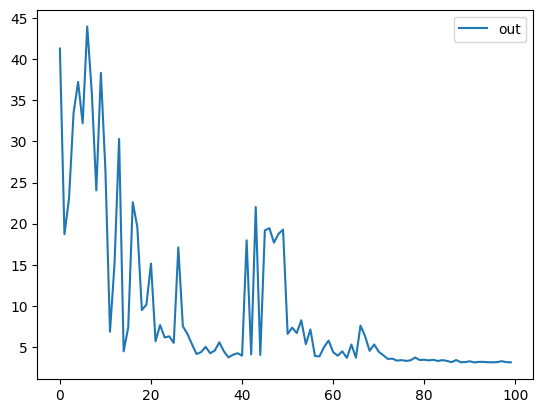

In [34]:
out_df.plot()

In [35]:
out_df.min()

out    3.138063
dtype: float64

In [36]:
out_df[out_df['out']==out_df['out'].min()]

,out
91,3.138063


## Result
* 사실 30부근에서 멈춰도 충분했던 것으로 보인다.

In [37]:
attr_df.describe()

,attr
count,1.440000e+03
mean,1.973730e-17
std,1.000347e+00
min,-1.836693e+00
25%,-4.809732e-01
50%,-1.272246e-01
75%,2.933487e-01
max,1.367771e+01
